## 🚀 Quick Start
Here's a simple example using a pretrained DeepSDF model, lattice structure generation, and deformation:

In [42]:
from DeepSDFStruct.pretrained_models import get_model, PretrainedModels
from DeepSDFStruct.SDF import SDFfromDeepSDF
from DeepSDFStruct.lattice_structure import LatticeSDFStruct
from DeepSDFStruct.parametrization import Constant
from DeepSDFStruct.torch_spline import TorchSpline
import splinepy
import torch

### Load a pretrained DeepSDF model

In [43]:
model = get_model(PretrainedModels.AnalyticRoundCross)
sdf = SDFfromDeepSDF(model)

### Set the latent vector and visualize a slice of the SDF

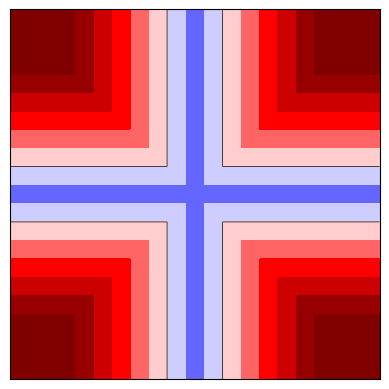

In [44]:
sdf.set_latent_vec(torch.tensor([0.3]))
_ = sdf.plot_slice(origin=(0.5, 0.5, 0.5))

### Define a spline-based deformation field

In [45]:
deformation_spline = TorchSpline(splinepy.helpme.create.box(1, 1, 1).bspline)

### Create the lattice structure with deformation and microtile

In [46]:
lattice_struct = LatticeSDFStruct(
    tiling=(3, 3, 1),
    deformation_spline=deformation_spline,
    microtile=sdf,
    parametrization=Constant([0.5], device=model.device),
)

### Visualize a slice of the final lattice structure

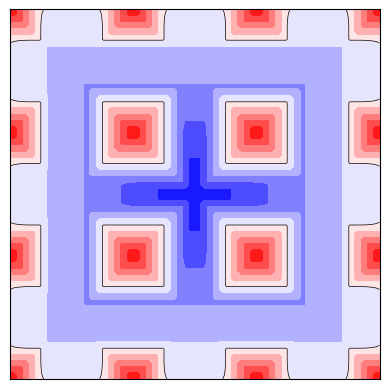

In [47]:
_ = lattice_struct.plot_slice(origin=(0, 0, 0.5))

Since all SDFs are callable, the signed distance can be obtained by calling e.g.

In [48]:
lattice_struct(torch.tensor([[0, 0, 0], [0, 1, 0]], dtype=torch.float32))

tensor([0.9142, 0.9142])

Furthermore, a differentiable surface mesh can be extracted and exported

In [49]:
from DeepSDFStruct.mesh import create_3D_surface_mesh, export_surface_mesh
surf_mesh, derivative = create_3D_surface_mesh(
    lattice_struct, 30, differentiate=True
)
export_surface_mesh(
    "mesh_with_derivative.vtk",surf_mesh, derivative
)

Mesh saved to mesh_with_derivative.vtk


The libraries gustaf and meshio can be used to export the mesh to differnt formats.

In [50]:
import gustaf as gus
faces = surf_mesh.to_gus()
gus.io.meshio.export("faces.inp", faces)
gus.io.meshio.export("faces.obj", faces)

Finally, there is also a functionality to create a volumetric mesh from the generated surface mesh.

In [51]:
from DeepSDFStruct.mesh import tetrahedralize_surface
volumes, _ = tetrahedralize_surface(faces)
gus.io.mfem.export("volumes.mfem", volumes)

### Training a Model
A model can be trained by using the `train_deep_sdf` function that takes as input the experiment directory and the data directory.`train_deep_sdf("DeepSDFStruct/trained_models/test_experiment", data_dir)`

In [52]:
from DeepSDFStruct.deep_sdf.training import train_deep_sdf

Example data can be downloaded from huggingface

In [53]:
from huggingface_hub import snapshot_download
data_dir = snapshot_download(
    "mkofler/lattice_structure_unit_cells", repo_type="dataset"
)
train_deep_sdf("DeepSDFStruct/trained_models/test_experiment", data_dir)

Fetching 124 files: 100%|██████████| 124/124 [00:00<00:00, 5607.48it/s]
05:32:01 Experiment description: 
This experiment is intented for testing purposes only.
05:32:01 training on NVIDIA RTX 4000 SFF Ada Generation
05:32:01 Setting random seed to 42
05:32:01 There are 20 scenes
05:32:01 starting from epoch 1
05:32:01 Number of decoder parameters: 5530
05:32:01 Number of shape code parameters: 20 (# codes 20, code dim 1)
05:32:01 Finished epoch     1/10 | with Reg.: 0.0000 and Tot.: 0.0711 [10.00%] in 0:00:01 (0.13s/epoch)
05:32:01 Finished epoch     2/10 | with Reg.: 0.0000 and Tot.: 0.0668 [20.00%] in 0:00:01 (0.13s/epoch)
05:32:01 Finished epoch     3/10 | with Reg.: 0.0000 and Tot.: 0.0641 [30.00%] in 0:00:01 (0.13s/epoch)
05:32:01 Finished epoch     4/10 | with Reg.: 0.0000 and Tot.: 0.0621 [40.00%] in 0:00:01 (0.13s/epoch)
05:32:01 Finished epoch     5/10 | with Reg.: 0.0000 and Tot.: 0.0615 [50.00%] in 0:00:01 (0.13s/epoch)
05:32:01 Finished epoch     6/10 | with Reg.: 0.0000 a

Note that this data contains the preprocessed and sampled data. 
The data that is used for training a DeepSDF model needs to be in the form of `.npz` files that contain the negative and positive points as an [x,y,z] array.
This can be achieved by using numpy's export function:
```python
np.savez(file_name, neg=neg_points, pos=pos_points)
```

### Generation of Training Data
Different types of geometry representations can be used for training. One possibility is to use the python library splinepy:

In [54]:
import splinepy
import numpy as np
from DeepSDFStruct.sampling import SDFSampler
from DeepSDFStruct.splinepy_unitcells.chi_3D import Chi3D
from DeepSDFStruct.splinepy_unitcells.cross_lattice import CrossLattice

outdir = "./training_data"
splitdir = "./training_data/splits"
dataset_name = "microstructure"

sdf_sampler = SDFSampler(outdir, splitdir, dataset_name)

t_start = 0.1 * np.sqrt(2) / 2
t_end = 0.15 * np.sqrt(2) / 2
crosslattice_tiles = []
for t in np.linspace(t_start, t_end, 3):
    tile, _ = CrossLattice().create_tile(np.array([[t]]), make3D=True)
    crosslattice_tiles.append(splinepy.Multipatch(tile))

chi = Chi3D()
chi_tiles = []

for phi in np.linspace(0, -np.pi / 6, 2):
    for x2 in np.linspace(-0.1, 0.2, 2):
        t = 0.1
        x1 = 0.2
        r = 0.5 * t
        tile, _ = chi.create_tile(np.array([[phi, t, x1, x2, r]] * 5))
        chi_tiles.append(splinepy.Multipatch(tile))

sdf_sampler.add_class(chi_tiles, class_name="Chi3D_center")
sdf_sampler.add_class(crosslattice_tiles, class_name="CrossLattice")

sdf_sampler.process_geometries(
    sampling_strategy="uniform", n_faces=100, compute_mechanical_properties=False
)

sdf_sampler.write_json("chi_and_cross.json")

05:32:02 processing geometry list Chi3D_center
Processing instances:   0%|          | 0/4 [00:00<?, ?it/s]05:32:02 File training_data/microstructure/Chi3D_center/Chi3D_center_00000.npz already exists
05:32:02 File training_data/microstructure/Chi3D_center/Chi3D_center_00001.npz already exists
05:32:02 File training_data/microstructure/Chi3D_center/Chi3D_center_00002.npz already exists
05:32:02 File training_data/microstructure/Chi3D_center/Chi3D_center_00003.npz already exists
Processing instances: 100%|██████████| 4/4 [00:00<00:00, 1058.30it/s]
05:32:02 processing geometry list CrossLattice
Processing instances:   0%|          | 0/3 [00:00<?, ?it/s]05:32:02 File training_data/microstructure/CrossLattice/CrossLattice_00000.npz already exists
05:32:02 File training_data/microstructure/CrossLattice/CrossLattice_00001.npz already exists
05:32:02 File training_data/microstructure/CrossLattice/CrossLattice_00002.npz already exists
Processing instances: 100%|██████████| 3/3 [00:00<00:00, 110